# Estimating CPRS

This notebook estimates [Chronos Bolt](https://github.com/amazon-science/chronos-forecasting)'s zero-shot CRPS on each pretraining dataset. Read [this](https://docs.google.com/document/d/1LsKQ9I4i4xLwhiywDrFUkeVAsybitqUAkZ9S9VKRKC4/edit?tab=t.0#heading=h.gz7sst7uli2g) for a more detailed explanation.

<hr>

## Data

### Loading

Load each train-test dataset's time series features and their respective zero-shot CRPS from Chronos-Bolt.

In [24]:
import pandas as pd
from pathlib import Path

split_name = "train_test"
input_path = Path("resources") / split_name / "features.csv"

df = pd.read_csv(input_path)
df.head()

name   term freq  prediction_length     domain     trend   
0  loop_seattle  short   5T                 48  Transport  0.594711  \
1  loop_seattle  short    D                 30  Transport  0.500107   
2  loop_seattle  short    H                 48  Transport  0.446253   
3       m_dense  short    D                 30  Transport  0.729707   
4       m_dense  short    H                 48  Transport  0.397013   

   seasonal_strength   entropy     hurst  stability  lumpiness  
0           0.280343  0.589723  0.936951   0.458372   0.613632  
1           0.769271  0.576937  0.611051   0.170957   0.339067  
2           0.630205  0.656869  0.689547   0.211964   0.454267  
3           0.741856  0.681616  0.744518   0.353943   0.367117  
4           0.802983  0.477337  0.588340   0.113609   0.155365

### Preprocessing

#### `NaN`s 

Check if there are any rows with one or more `NaN`s in the time series feature columns.

In [25]:
from IPython.display import display

df_nan = df[df.isnull().any(axis=1)].reset_index(drop=True)

print(f"Number of rows with NaNs in time series features: {len(df_nan)}")

print("Datasets with missing features:")
for index, row in df_nan.iterrows():
    print(f"  {row['name']}/{row['freq']} ({row['term']})")

display(df_nan)

Number of rows with NaNs in time series features: 7
Datasets with missing features:
  hierarchical_sales/D (short)
  m4_yearly/A (short)
  solar/H (short)
  temperature_rain_with_missing/D (short)
  bizitobs_l2c/H (medium)
  solar/H (medium)
  solar/H (long)


name    term freq  prediction_length   
0             hierarchical_sales   short    D                 30  \
1                      m4_yearly   short    A                  6   
2                          solar   short    H                 48   
3  temperature_rain_with_missing   short    D                 30   
4                   bizitobs_l2c  medium    H                480   
5                          solar  medium    H                480   
6                          solar    long    H                720   

         domain     trend  seasonal_strength   entropy     hurst  stability   
0         Sales  1.000000           1.000000  0.000000       NaN        NaN  \
1      Econ/Fin  0.942347                NaN  0.499465  0.957853   0.811223   
2        Energy  0.392161           0.887099  0.411896       NaN   0.060786   
3        Nature       NaN                NaN       NaN       NaN        NaN   
4  Web/CloudOps  0.860124           0.203657  0.413234       NaN   0.736321   
5        Energy  0.396826           0.880060  0.410616       NaN   0.064802   
6        Energy  0.391212           0.850250  0.422815       NaN   0.077194   

   lumpiness  
0        NaN  
1   0.101500  
2   0.280778  
3        NaN  
4   0.202554  
5   0.295527  
6   0.347750

Remove rows with one or more `NaN`s in the time series feature columns.

In [26]:
initial_rows = len(df)

features = [
    "trend",
    "seasonal_strength",
    "entropy",
    "hurst",
    "stability",
    "lumpiness",
]

df = df.dropna(subset=features)
num_dropped = initial_rows - len(df)
print(f"Number of rows dropped: {num_dropped}")

Number of rows dropped: 7


#### Domains

Use an [ordinal encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) to encode each domain as an integer.

In [27]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

df["domain"] = enc.fit_transform(df[["domain"]])
df.head()

name   term freq  prediction_length  domain     trend   
0  loop_seattle  short   5T                 48     5.0  0.594711  \
1  loop_seattle  short    D                 30     5.0  0.500107   
2  loop_seattle  short    H                 48     5.0  0.446253   
3       m_dense  short    D                 30     5.0  0.729707   
4       m_dense  short    H                 48     5.0  0.397013   

   seasonal_strength   entropy     hurst  stability  lumpiness  
0           0.280343  0.589723  0.936951   0.458372   0.613632  
1           0.769271  0.576937  0.611051   0.170957   0.339067  
2           0.630205  0.656869  0.689547   0.211964   0.454267  
3           0.741856  0.681616  0.744518   0.353943   0.367117  
4           0.802983  0.477337  0.588340   0.113609   0.155365

#### Frequencies

Encode each frequency as its corresponding number of preiods per year.

In [28]:
import numpy as np
import re

SECONDS_PER_YEAR = 365 * 24 * 60 * 60


def freq_to_seconds(freq_str: str) -> float:
    """
    Convert a frequency string (e.g., 'T', '15T', etc.) into its equivalent
    duration in seconds.

    The function extracts a optional numeric multiplier and a time unit from
    the input string and calculates the total duration in seconds based on a
    predefined mapping of time units.

    Supported units:
    - 'S' : second
    - 'T' : minute (60 seconds)
    - 'H' : hour (3600 seconds)
    - 'D' : day (86400 seconds)
    - 'W' : week (604800 seconds)
    - 'M' : month (approximated as 30 days)
    - 'Q' : quarter (approximated as 91 days)
    - 'Y' : year (approximated as 365 days)

    Args:
        freq_str (str): A frequency string composed of:
        - An optional 1-2 digit integer
        - An uppercase time unit.

    Returns:
        float: The equivalent number of seconds, or np.nan if the format is
            invalid.
    """
    match = re.match(r"^(\d{1,2})?([A-Z]+)", freq_str)
    if not match:
        return np.nan

    num_str, freq = match.groups()
    num = int(num_str) if num_str is not None else 1

    freq_map = {
        "S": 1,
        "T": 60,  # minute
        "H": 3600,
        "D": 86400,
        "W": 7 * 86400,
        "M": 30 * 86400,
        "Q": 91 * 86400,
        "Y": 365 * 86400,
    }

    if freq not in freq_map:
        return np.nan

    return num * freq_map[freq]


def freq_to_periods(freq_str: str) -> float:
    """
    Convert a frequency string into the approximate number of periods per year.

    Example:
    - 'D' -> 365 (daily)
    - 'H' -> 8760 (hourly)
    - 'Q' -> ~4.01 (quarterly)
    - '5T' -> 105120 (every 5 minutes)

    Args:
        freq_str (str): A frequency string composed of an optional numeric
        prefix (up to 2 digits) followed by a time unit (e.g., '5T', 'Q',
        'D').

    Returns:
        float: Approximate number of periods per year for the given frequency.
            Returns np.nan if the input is invalid or cannot be parsed.
    """
    seconds = freq_to_seconds(freq_str)
    return np.nan if pd.isna(seconds) else SECONDS_PER_YEAR / seconds


df["freq"] = df["freq"].apply(freq_to_periods)
df.head()

name   term      freq  prediction_length  domain     trend   
0  loop_seattle  short  105120.0                 48     5.0  0.594711  \
1  loop_seattle  short     365.0                 30     5.0  0.500107   
2  loop_seattle  short    8760.0                 48     5.0  0.446253   
3       m_dense  short     365.0                 30     5.0  0.729707   
4       m_dense  short    8760.0                 48     5.0  0.397013   

   seasonal_strength   entropy     hurst  stability  lumpiness  
0           0.280343  0.589723  0.936951   0.458372   0.613632  
1           0.769271  0.576937  0.611051   0.170957   0.339067  
2           0.630205  0.656869  0.689547   0.211964   0.454267  
3           0.741856  0.681616  0.744518   0.353943   0.367117  
4           0.802983  0.477337  0.588340   0.113609   0.155365

<hr>

## XGBoost Tree

### Training

We're going to train an [XGBoost tree](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) on each train-test dataset's time series features to predict Chronos-Bolt's CRPS on the dataset.

1. Split the DataFrame into a training split and a test split.

In [29]:
from sklearn.model_selection import train_test_split


X, y = df[features], df["true_crps"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

print(f"X columns: {X_train.columns.tolist()}")
print(f"y column: {y_train.name}")

KeyError: 'true_crps'

2. Use [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#gridsearchcv) and [leave-one-out cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) to perform hyperparameter optimization.

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut

# TODO: Consider playing around with params to decrease CV MSE
param_grid = {
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [100, 200],
}
grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=LeaveOneOut(),
    scoring="neg_mean_squared_error",
    verbose=1,
).fit(X_train, y_train)

print(f"[Grid Search] Best parameters: {grid.best_params_}")
print(f"[Grid Search] Best cross-validation MSE: {-grid.best_score_:.3f}")

Fitting 72 folds for each of 8 candidates, totalling 576 fits
[Grid Search] Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
[Grid Search] Best cross-validation MSE: 0.033


3. Save the best XGBoost tree.

In [ ]:
estimator_path = Path("xgboost") / split_name / "crps.json"
estimator_path.parent.mkdir(parents=True, exist_ok=True)

print(f"Saving best XGBoost tree to: {estimator_path}")
estimator = grid.best_estimator_
estimator.save_model(str(estimator_path))

Saving best XGBoost tree to: xgboost\train_test\crps.json


4. Compare the best XGBoost tree to training and evaluating a [dummy model](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor)

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error


dummy = DummyRegressor().fit(X_train, y_train)
base_mse = mean_squared_error(y_test, dummy.predict(X_test))
print(f"[Dummy] Test MSE: {base_mse:.3f}")

y_pred = estimator.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"[XGBoost] Test MSE: {mse:.3f}")

[Dummy] Test MSE: 0.047
[XGBoost] Test MSE: 0.005


5. Plot each feature's [importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.plot_importance) in predicting Chronos-Bolt's CRPS.

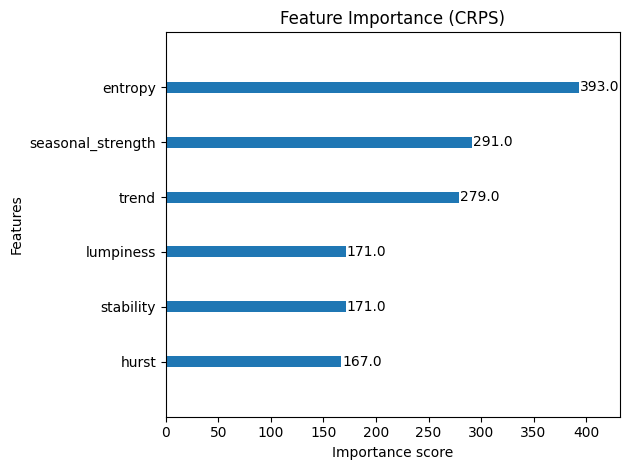

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

ax = plot_importance(estimator)
ax.set_title("Feature Importance (CRPS)")
ax.grid(False)
plt.tight_layout()

plot_dirpath = Path("plots") / "xgboost" / split_name
plot_path = plot_dirpath / "crps_importance.png"
plot_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(plot_path, dpi=300)
plt.show()

<br>